# Gradient Descent using Golden-section search

## Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Functions for building plots

In [16]:
def plot_function_and_path(f, x_range, y_range, path, title):
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f([X[i, j], Y[i, j]])

    fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.8)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('f(X, Y)')

    if len(path) > 0:
        path_x = [p[0] for p in path]
        path_y = [p[1] for p in path]
        path_z = [f([x, y]) for x, y in zip(path_x, path_y)]
        ax1.plot(path_x, path_y, path_z, 'r-o', linewidth=2)

    ax2 = fig.add_subplot(122)
    contour = ax2.contour(X, Y, Z, 20, cmap=cm.coolwarm)
    fig.colorbar(contour, ax=ax2)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')

    if len(path) > 0:
        path_x = [p[0] for p in path]
        path_y = [p[1] for p in path]
        ax2.plot(path_x, path_y, 'r-o', linewidth=2)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_convergence(f_values, iterations, title):
    plt.figure(figsize=(10, 6))
    iterations = iterations[:len(f_values)-1]
    plt.plot(iterations, f_values[:-1], 'b-o')
    plt.xlabel('Iteration')
    plt.ylabel('Function Value')
    plt.title(title)
    plt.grid(True)
    plt.show()

## Functions and gradients

In [24]:
def f1(x):
    return (x[0] - 3) ** 2 + (x[1] + 2) ** 2

def grad_f1(x):
    return np.array([2 * (x[0] - 3), 2 * (x[1] + 2)])

def f2(x):
    return 2 * (x[0] + 2) ** 2 + 4 * x[0] * x[1] + 3 * (x[1] - 4) ** 2

def grad_f2(x):
    return np.array([
        4 * (x[0] + 2) + 4 * x[1],
        4 * x[0] + 6 * (x[1] - 4)
    ])

def f3(x):
    return (8 * (x[0] - 3) ** 2) + ((x[1] + 1) ** 2)

def grad_f3(x):
    return np.array([16 * (x[0] - 3), 2 * (x[1] + 1)])


## Golden section search method

In [4]:
def golden_section_search(f, a, b, tol=1e-6, max_iter=100):
    golden_ratio = (np.sqrt(5) - 1) / 2

    x1 = b - golden_ratio * (b - a)
    x2 = a + golden_ratio * (b - a)
    f1 = f(x1)
    f2 = f(x2)

    for _ in range(max_iter):
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + golden_ratio * (b - a)
            f2 = f(x2)
        else:
            b = x2
            x2 = x1
            f2 = f1
            x1 = b - golden_ratio * (b - a)
            f1 = f(x1)

        if abs(b - a) < tol:
            break

    return (a + b) / 2


## Gradient descent with golden section search

In [22]:
def gradient_descent_GS(f, grad_f, x0, tol=1e-6, max_iter=1000):
    x = np.array(x0, dtype=float)
    f_values = [f(x)]
    iterations = []
    # Saving path for later visualization
    path = [x.copy()]

    for i in range(max_iter):
        iterations.append(i)
        g = grad_f(x)

        if np.linalg.norm(g) < tol:
            break

        d = -g

        def f_along_line(alpha):
            return f(x + alpha * d)

        # Using golden section method to get coefficient
        alpha = golden_section_search(f_along_line, 0, 1.0)

        x_new = x + alpha * d
        path.append(x_new.copy())

        if np.linalg.norm(x_new - x) < tol:
            x = x_new
            f_values.append(f(x))
            break

        x = x_new
        f_values.append(f(x))

    return x, f_values, iterations, path

## Usage


Optimizing Function 1: (x - 3)^2 + (y + 2)^2
Minimum found at [ 3. -2.], value: 1.5817331681450725e-25


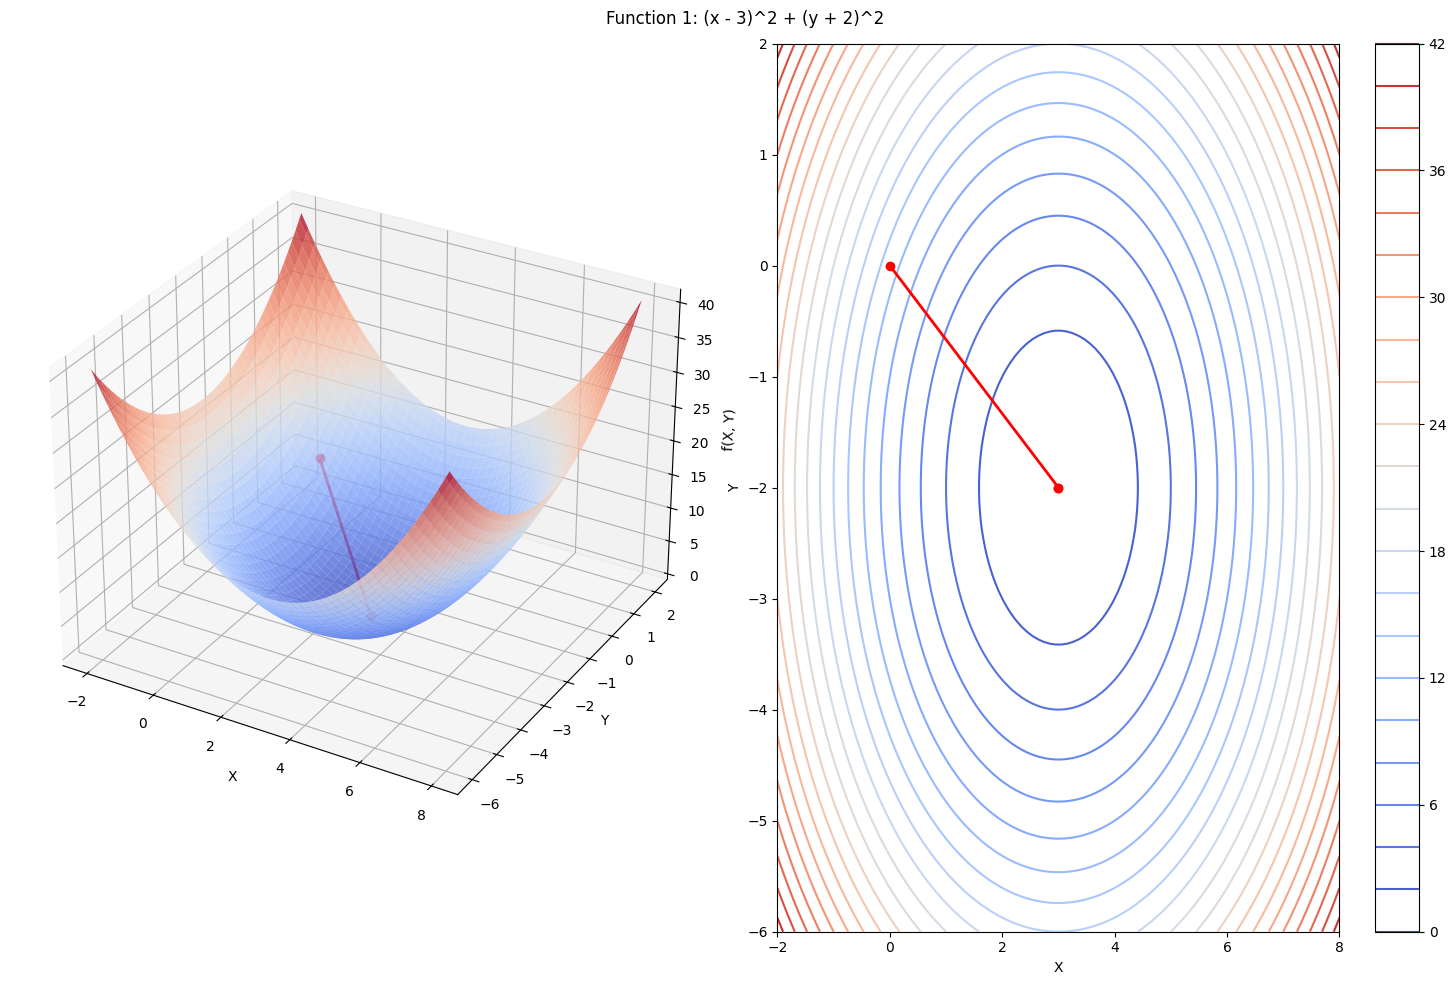

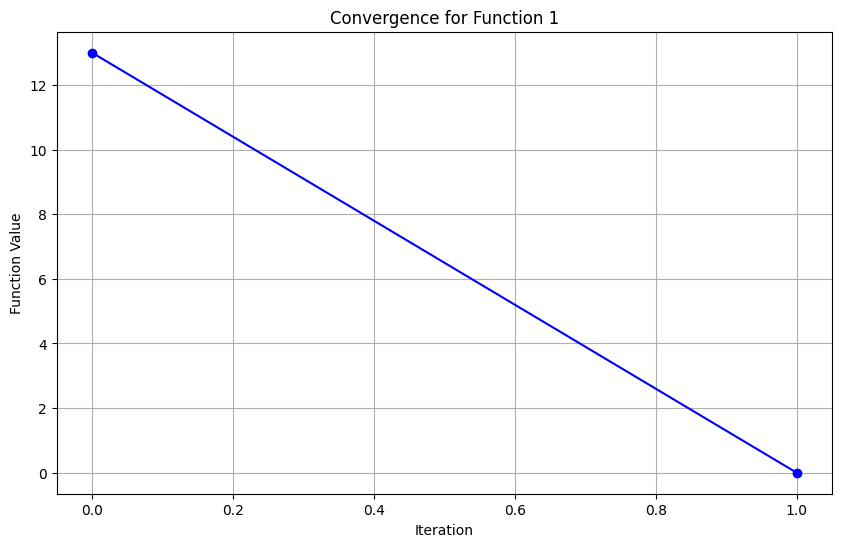


Optimizing Function 2: 2(x + 2)^2 + 4xy + 3(y - 4)^2
Minimum found at [-17.99999849  15.99999867], value: -207.99999999999824


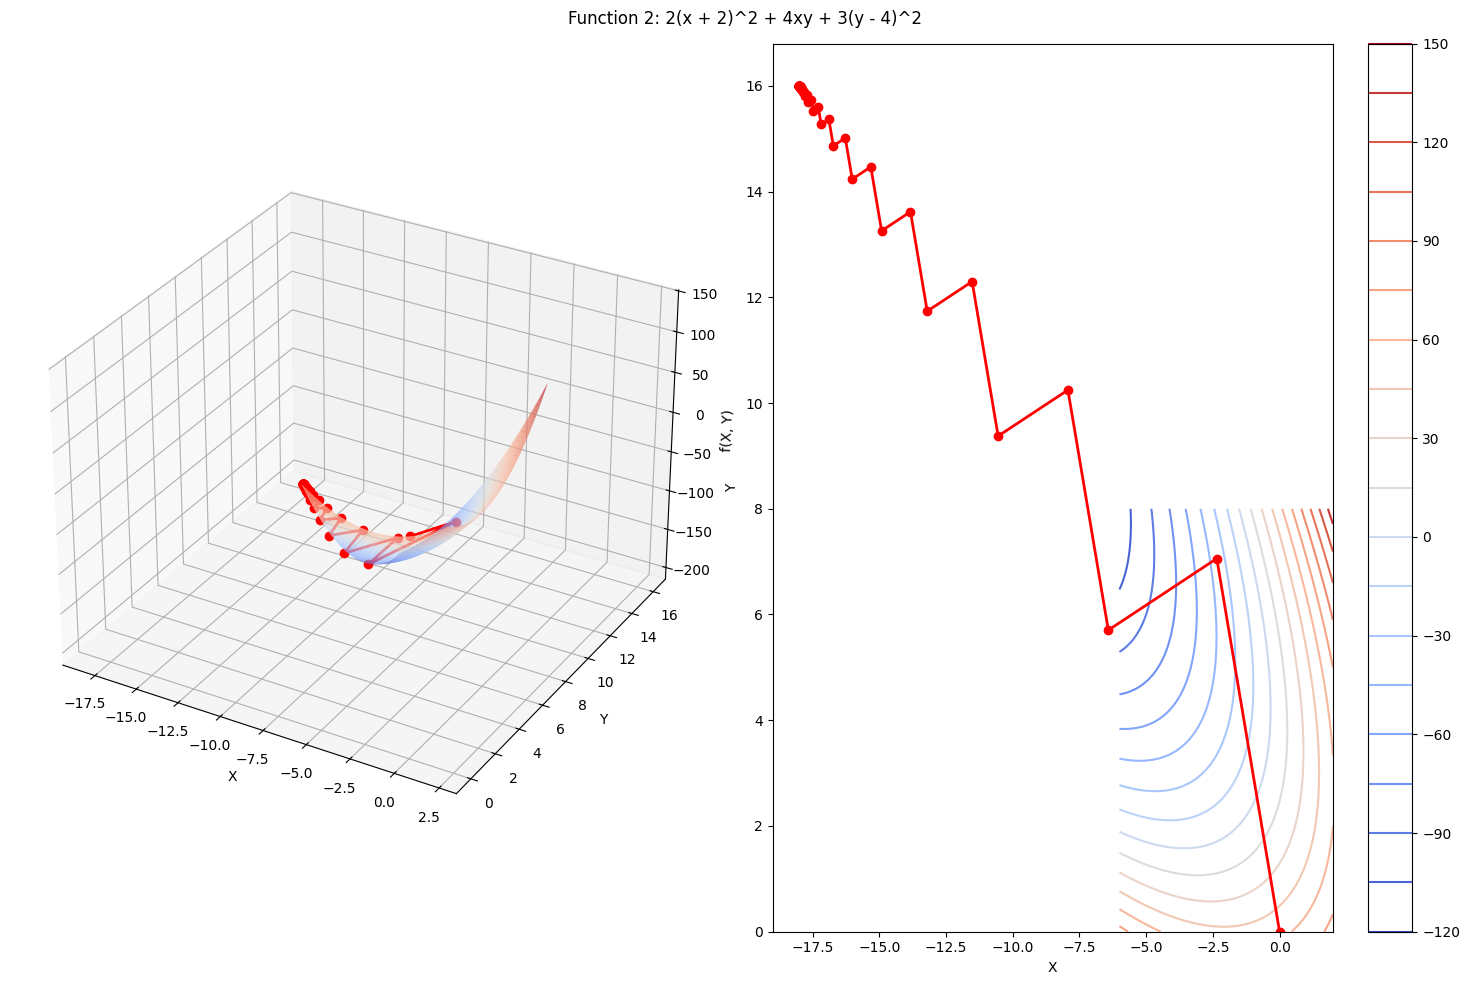

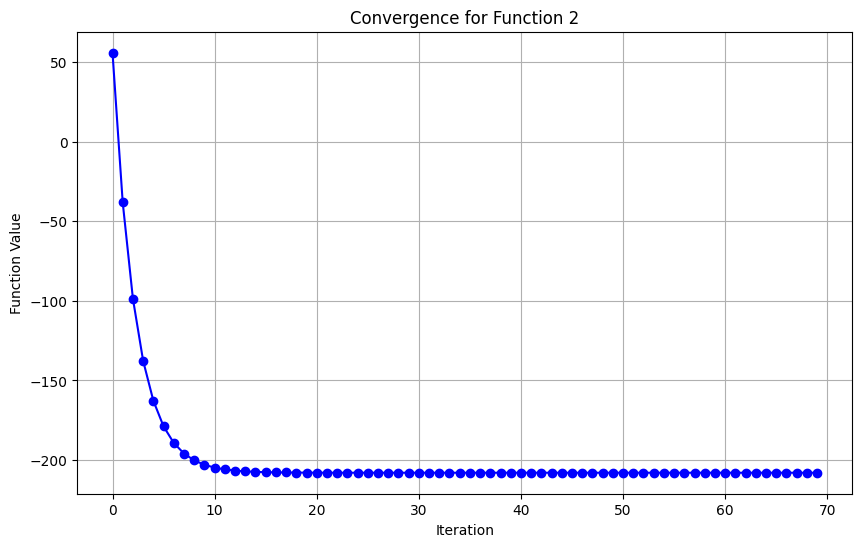


Optimizing Function 3: 8(x - 3)^2 + (y + 1)^2
Minimum found at [ 2.99999996 -0.99999999], value: 1.0625092444676922e-14


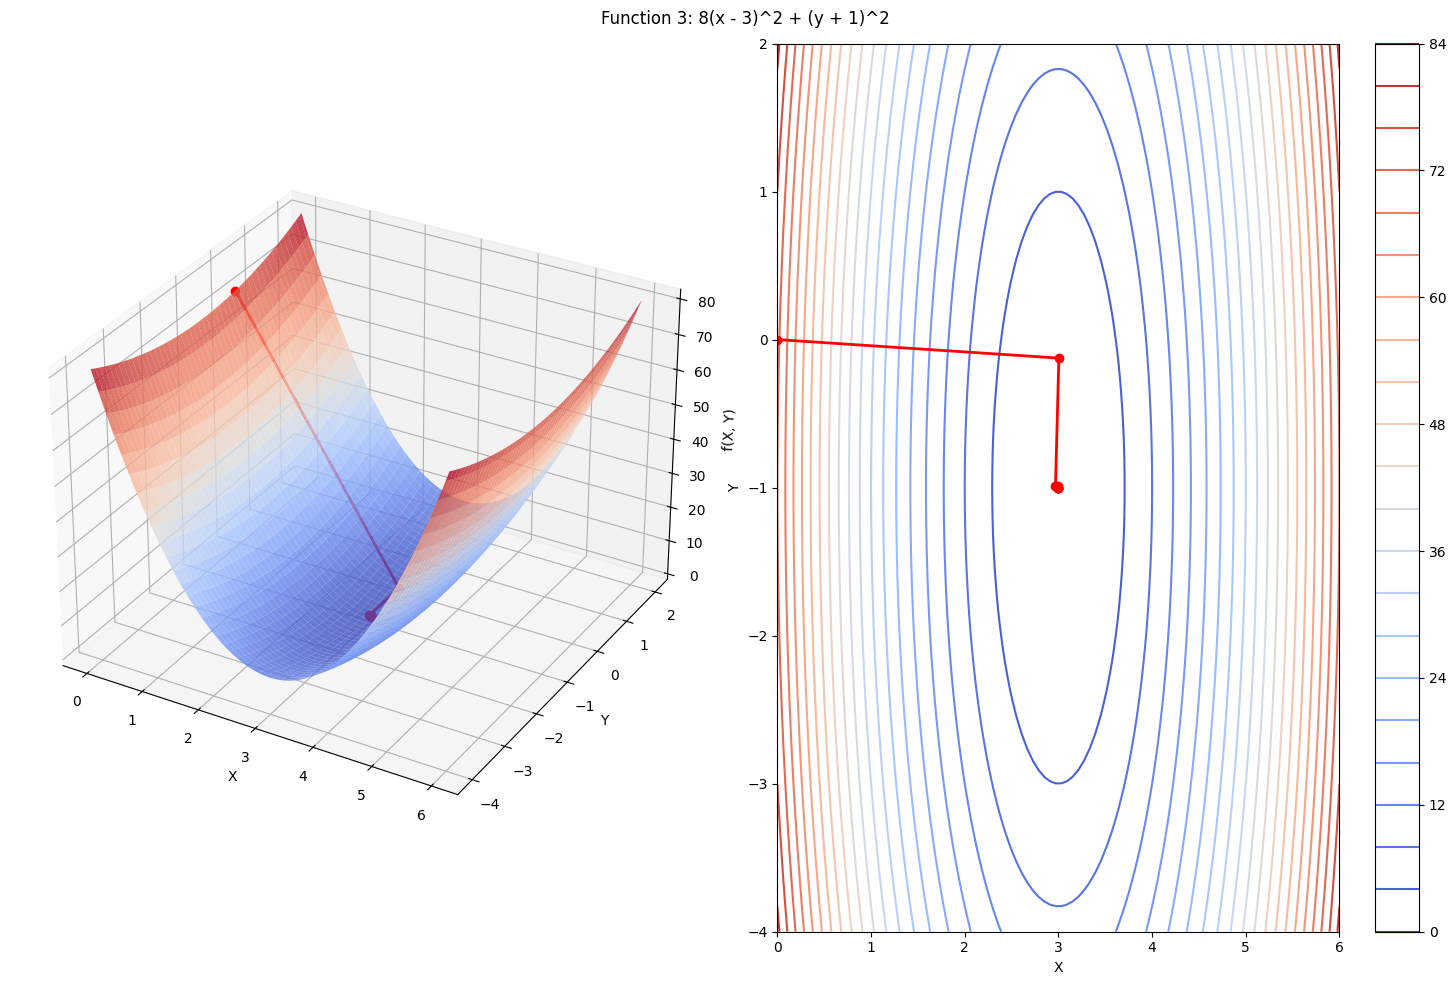

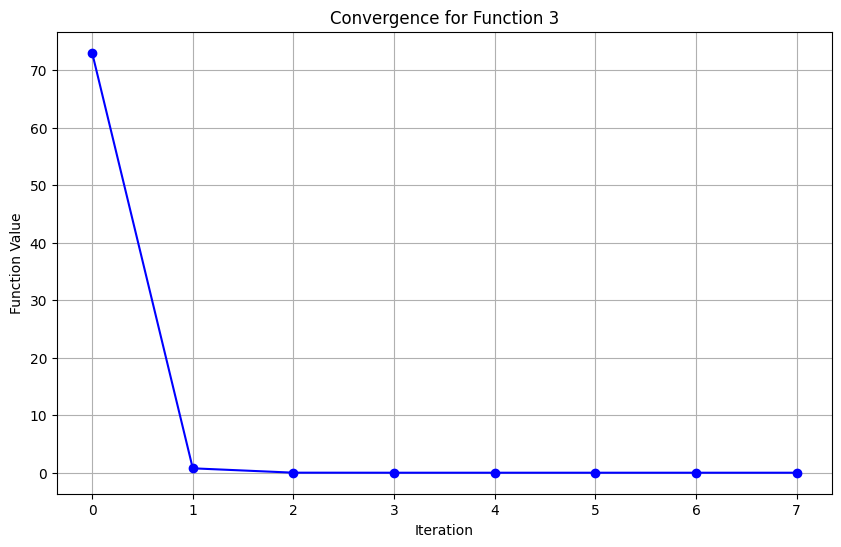

In [25]:
def optimize_and_visualize(f, grad_f, x0, x_range, y_range, function_name, function_description):
    print(f"\nOptimizing {function_name}: {function_description}")

    x_opt, f_values, iterations, path = gradient_descent_GS(f, grad_f, x0)
    print(f"Minimum found at {x_opt}, value: {f(x_opt)}")

    plot_function_and_path(f, x_range, y_range, path, f"{function_name}: {function_description}")
    plot_convergence(f_values, iterations, f"Convergence for {function_name}")

    return x_opt, f_values, iterations, path

x0 = [0, 0]

x_opt1, f_values1, iterations1, path1 = optimize_and_visualize(
    f1, grad_f1, x0, [-2, 8], [-6, 2],
    "Function 1", "(x - 3)^2 + (y + 2)^2"
)

x_opt2, f_values2, iterations2, path2 = optimize_and_visualize(
    f2, grad_f2, x0, [-6, 2], [0, 8],
    "Function 2", "2(x + 2)^2 + 4xy + 3(y - 4)^2"
)

x_opt3, f_values3, iterations3, path3 = optimize_and_visualize(
    f3, grad_f3, x0, [0, 6], [-4, 2],
    "Function 3", "8(x - 3)^2 + (y + 1)^2"
)